In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(37) # 使得每次运行得到的随机数都一样

In [2]:
# 准备数据集
data_path='E:\PyProjects\DataSet\WholeSaleCustomer/Wholesale customers data.csv'
df=pd.read_csv(data_path)
print(df.info()) # 查看数据信息，确保没有错误
# print('-'*100)
dataset=df.values # 数据加载没有问题
# print(dataset.shape) # ((441, 8)
dataset=dataset[:,2:]# 本项目只需要后面的6列features即可
col_names=df.columns.tolist()[2:]
print(col_names)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB
None
['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


In [3]:
# 无标签数据集可视化，将第一列feature作为X，第二列feature作为y
def visual_2D_dataset_dist(dataset):
    '''将二维数据集dataset显示在散点图中'''
    assert dataset.shape[1]==2,'only support dataset with 2 features'
    plt.figure()
    X=dataset[:,0]
    Y=dataset[:,1]
    plt.scatter(X,Y,marker='v',c='g',label='dataset')
    
    X_min,X_max=np.min(X)-1,np.max(X)+1
    Y_min,Y_max=np.min(Y)-1,np.max(Y)+1
    plt.title('dataset distribution')
    plt.xlim(X_min,X_max)
    plt.ylim(Y_min,Y_max)
    plt.xlabel('feature_0')
    plt.ylabel('feature_1')
    plt.legend()


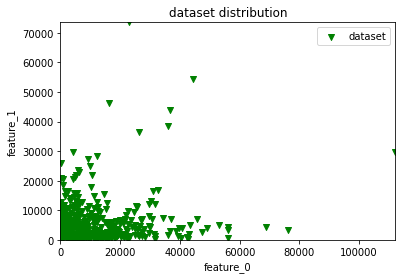

In [4]:
visual_2D_dataset_dist(dataset[:,:2]) # X=fresh， y=milk

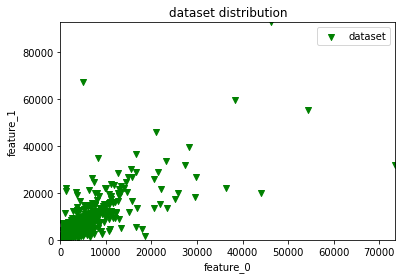

In [5]:
visual_2D_dataset_dist(dataset[:,1:3]) # X=milk， y=gricery

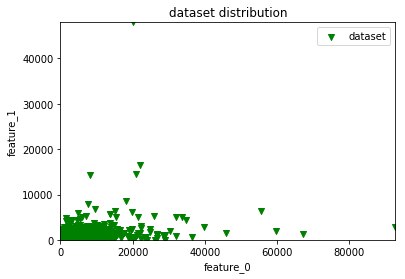

In [6]:
visual_2D_dataset_dist(dataset[:,[2,5]]) # X=grocery， y=Delicassen

In [7]:
# 构建均值漂移聚类模型
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth=estimate_bandwidth(dataset,quantile=0.8,
                             n_samples=len(dataset))
meanshift=MeanShift(bandwidth=bandwidth,bin_seeding=True)
meanshift.fit(dataset) # 使用评估的带宽构建均值漂移模型，并进行训练
labels=meanshift.labels_
cluster_num=len(np.unique(labels))
centroids=meanshift.cluster_centers_
# 下面打印出簇群种类，和质心位置信息
print('Number of Clusters: {}'.format(cluster_num))
print('\t'.join([col_name[:5] for col_name in col_names]))
for centroid in centroids:
    print('\t'.join(str(int(x)) for x in centroid))

Number of Clusters: 8
Fresh	Milk	Groce	Froze	Deter	Delic
9632	4671	6593	2570	2296	1248
40204	46314	57584	5518	25436	4241
16117	46197	92780	1026	40827	2944
22925	73498	32114	987	20070	903
112151	29627	18148	16745	4948	8550
36847	43950	20170	36534	239	47943
32717	16784	13626	60869	1272	5609
8565	4980	67298	131	38102	1215


In [8]:
def visual_cluster_effect(cluster,dataset,title,col_id):
    assert isinstance(col_id,list) and len(col_id)==2,'col_id must be list type and length must be 2'
    
    labels=cluster.labels_ # 每一个样本对应的簇群号码
#     print(labels.shape) # (440,) 440个样本
    markers=['.',',','o','v','^','<','>','1','2','3','4','8'
                 ,'s','p','*','h','H','+','x','D','d','|']
    colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
            'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    
    # 将数据集绘制到图表中
    plt.figure()
    for class_id in set(labels):
        one_class=dataset[class_id==labels]
        print('label: {}, smaple_num: {}'.format(class_id,len(one_class)))
        plt.scatter(one_class[:,0],one_class[:,1],marker=markers[class_id%len(markers)],
                    c=colors[class_id%len(colors)],label='class_'+str(class_id))
    plt.legend()
        
    # 将中心点绘制到图中
    centroids=meanshift.cluster_centers_
#     print(centroids.shape)# eg (8, 6) 8个簇群，6个features
    plt.scatter(centroids[:,col_id[0]],centroids[:,col_id[1]],marker='o',
                s=100,linewidths=2,color='k',zorder=5,facecolors='b')
    plt.title(title) 
    plt.xlabel('feature_0')
    plt.ylabel('feature_1')
    plt.show()

label: 0, smaple_num: 428
label: 1, smaple_num: 3
label: 2, smaple_num: 1
label: 3, smaple_num: 1
label: 4, smaple_num: 3
label: 5, smaple_num: 1
label: 6, smaple_num: 1
label: 7, smaple_num: 2


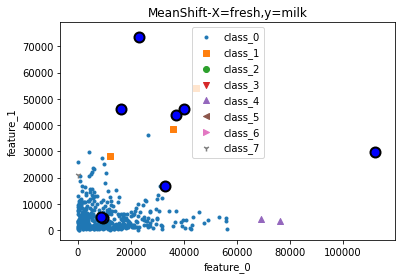

In [9]:

visual_cluster_effect(meanshift,dataset,'MeanShift-X=fresh,y=milk',[0,1]) # X=fresh， y=milk 

label: 0, smaple_num: 428
label: 1, smaple_num: 3
label: 2, smaple_num: 1
label: 3, smaple_num: 1
label: 4, smaple_num: 3
label: 5, smaple_num: 1
label: 6, smaple_num: 1
label: 7, smaple_num: 2


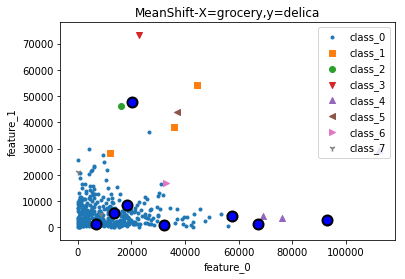

In [10]:
visual_cluster_effect(meanshift,dataset,'MeanShift-X=grocery,y=delica',[2,5]) # X=grocery， y=Delicassen

In [11]:
# 使用轮廓系数评估模型的优虐
from sklearn.metrics import silhouette_score
si_score=silhouette_score(dataset,meanshift.labels_,
                          metric='euclidean',sample_size=len(dataset))
print('si_score: {:.4f}'.format(si_score))

si_score: 0.6548
